# MediBuddy Insurance Cost Analysis & Prediction

## Business Objective
The objective of this project is to analyze customer demographics, health indicators,
and lifestyle factors to understand their impact on insurance claim amounts and to
build a predictive model that estimates the insurance cost for a policyholder.


In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")


 # Load Datasets

In [2]:
personal_df = pd.read_excel("../data/raw/personal_details.xlsx")
insurance_df = pd.read_excel("../data/raw/insurance_price.xlsx")

 # Initial Data Inspection

In [3]:
personal_df.head()


,Policy no.,children,smoker,region
0,PLC157006,0,no,southwest
1,PLC157033,1,no,southwest
2,PLC157060,0,no,southwest
3,PLC157087,1,no,southwest
4,PLC157186,5,no,southwest


In [4]:
insurance_df.head()

,Policy no.,age,sex,bmi,charges in INR
0,PLC156898,19,female,27.900,16884.92400
1,PLC156907,18,male,33.770,1725.55230
2,PLC156916,28,male,33.000,4449.46200
3,PLC156925,33,male,22.705,21984.47061
4,PLC156934,32,male,28.880,3866.85520


In [5]:
personal_df.shape

(1338, 4)

In [6]:
insurance_df.shape

(1338, 5)

# Data Type & Missing Value Check

In [7]:
personal_df.info()
personal_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Policy no.  1338 non-null   object
 1   children    1338 non-null   int64 
 2   smoker      1338 non-null   object
 3   region      1338 non-null   object
dtypes: int64(1), object(3)
memory usage: 41.9+ KB


Policy no.    0
children      0
smoker        0
region        0
dtype: int64

In [8]:
insurance_df.info()
insurance_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Policy no.      1338 non-null   object 
 1   age             1338 non-null   int64  
 2   sex             1338 non-null   object 
 3   bmi             1338 non-null   float64
 4   charges in INR  1338 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 52.4+ KB


Policy no.        0
age               0
sex               0
bmi               0
charges in INR    0
dtype: int64

# Duplicate Records Check

In [9]:
personal_df.duplicated().sum()
insurance_df.duplicated().sum()

np.int64(0)

# Merge Datasets

In [10]:
df = pd.concat([personal_df, insurance_df], axis=1)
df.shape

(1338, 9)

In [11]:
df.head()


,Policy no.,children,smoker,region,Policy no.,age,sex,bmi,charges in INR
0,PLC157006,0,no,southwest,PLC156898,19,female,27.900,16884.92400
1,PLC157033,1,no,southwest,PLC156907,18,male,33.770,1725.55230
2,PLC157060,0,no,southwest,PLC156916,28,male,33.000,4449.46200
3,PLC157087,1,no,southwest,PLC156925,33,male,22.705,21984.47061
4,PLC157186,5,no,southwest,PLC156934,32,male,28.880,3866.85520


# Data Cleaning & Preparation

In [12]:
df['smoker'] = df['smoker'].str.lower()
df['sex'] = df['sex'].str.lower()

# Univariate Analysis (Single Variable)

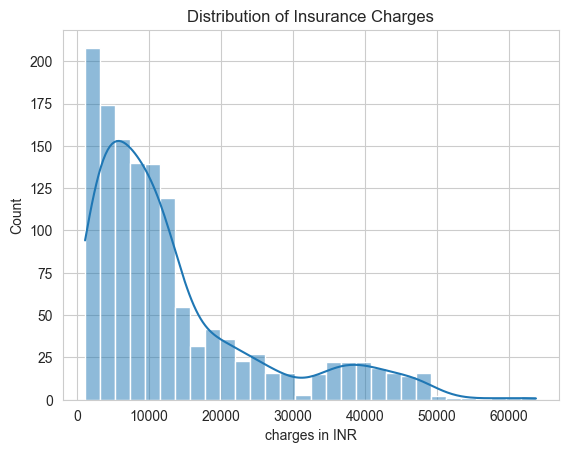

In [13]:
df.describe()
sns.histplot(df['charges in INR'], kde=True)
plt.title("Distribution of Insurance Charges")
plt.show()

In [14]:
 # Average Insurance Amount per Policy

In [15]:
average_policy_cost = df['charges in INR'].mean()
print(f"Average amount spent per policy cover: ₹{average_policy_cost:,.2f}")

Average amount spent per policy cover: ₹13,270.42


# Bivariate Analysis (Answer Business Questions)

In [16]:
# Gender vs Charges

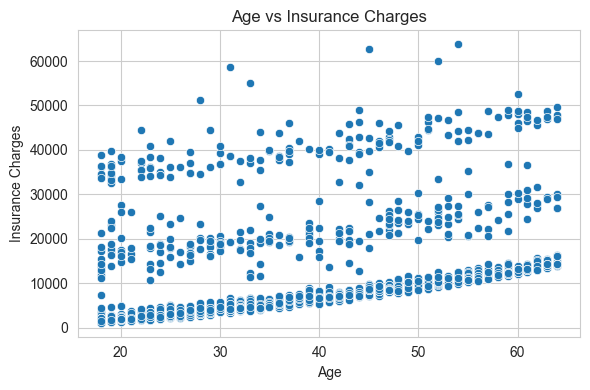

In [54]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='age', y='charges in INR', data=df)
plt.title("Age vs Insurance Charges")
plt.xlabel("Age")
plt.ylabel("Insurance Charges")

plt.tight_layout()
plt.savefig("outputs/age_vs_charges.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# Smoker vs Charges

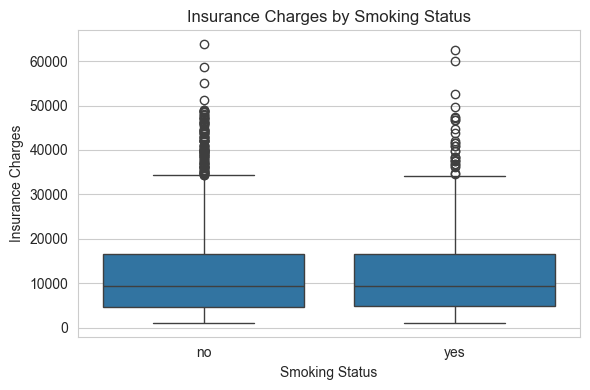

In [52]:
os.makedirs("Outputs", exist_ok=True)
plt.figure(figsize=(6,4))
sns.boxplot(x='smoker', y='charges in INR', data=df)
plt.title("Insurance Charges by Smoking Status")
plt.xlabel("Smoking Status")
plt.ylabel("Insurance Charges")

plt.tight_layout()
plt.savefig("Outputs/smoker_vs_charges.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
# BMI vs Charges

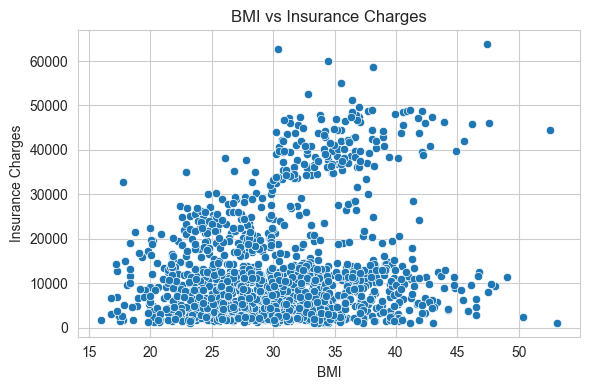

In [53]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='bmi', y='charges in INR', data=df)
plt.title("BMI vs Insurance Charges")
plt.xlabel("BMI")
plt.ylabel("Insurance Charges")

plt.tight_layout()
plt.savefig("outputs/bmi_vs_charges.png", dpi=300, bbox_inches="tight")
plt.show()

# Statistical Tests

In [22]:
# # Smoker vs Non-Smoker

In [23]:
smoker = df[df['smoker'] == 'yes']['charges in INR']
non_smoker = df[df['smoker'] == 'no']['charges in INR']

stats.ttest_ind(smoker, non_smoker)


TtestResult(statistic=np.float64(0.1866854040266426), pvalue=np.float64(0.8519356442350347), df=np.float64(1336.0))

# Correlation Analysis

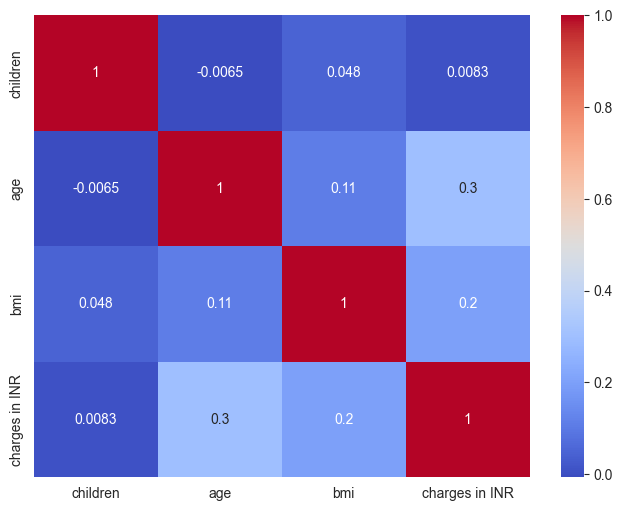

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# Feature Engineering

In [25]:
df['bmi_category'] = pd.cut(
    df['bmi'],
    bins=[0,18.5,25,30,100],
    labels=['underweight','normal','overweight','obese']
)


# Risk Segmentation

In [26]:
low_threshold = 9382.03
high_threshold = 16639.91

def risk_bucket(charges):
    if charges <= low_threshold:
        return 'Low Risk'
    elif charges <= high_threshold:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_segment'] = df['charges in INR'].apply(risk_bucket)
df['risk_segment'].value_counts()


risk_segment
Low Risk       669
High Risk      335
Medium Risk    334
Name: count, dtype: int64

In [27]:
df.groupby('risk_segment')['smoker'].value_counts(normalize=True)

risk_segment  smoker
High Risk     no        0.794030
              yes       0.205970
Low Risk      no        0.795217
              yes       0.204783
Medium Risk   no        0.796407
              yes       0.203593
Name: proportion, dtype: float64

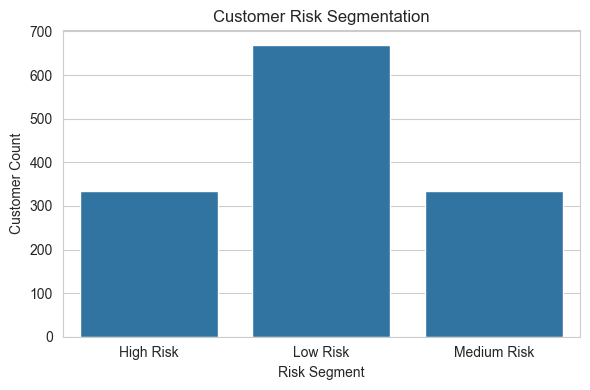

In [55]:
plt.figure(figsize=(6,4))
sns.countplot(x='risk_segment', data=df)
plt.title("Customer Risk Segmentation")
plt.xlabel("Risk Segment")
plt.ylabel("Customer Count")

plt.tight_layout()
plt.savefig("outputs/risk_segmentation.png", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
# Saving Cleaned Dataset

df.to_csv("data/insurance_cleaned.csv", index=False)

# Train-Test Split

In [28]:
X = df.drop('charges in INR', axis=1)
y = df['charges in INR']

cat_features = ['sex', 'smoker', 'region', 'bmi_category']
num_features = ['age', 'bmi', 'children']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Preprocessing Pipeline

In [29]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])


# Model Building (Baseline)

In [30]:
# Linear Regression

In [31]:
lr_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

# Model Evaluation

In [32]:
y_pred = lr_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2


(np.float64(11534.285782468747), 0.14305419932715946)

# Advanced Models

In [33]:
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

 # Hyperparameter Tuning

In [34]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20]
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also di

# Final Model Evaluation

In [35]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_best)),
r2_score(y_test, y_pred_best)


0.02719230494624747

In [63]:
model_metrics = pd.DataFrame({
    'Metric': ['RMSE', 'R2'],
    'Value': [rmse, r2]
})

model_metrics.to_csv("outputs/model_performance.csv", index=False)


In [65]:
joblib.dump(best_model, "outputs/final_model.pkl")

['outputs/final_model.pkl']

# Model Explainability

In [36]:
feature_names = best_model.named_steps['preprocess'].get_feature_names_out()
importances = best_model.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
1,num__bmi,0.408231
0,num__age,0.318171
2,num__children,0.091216
3,cat__sex_male,0.042530
4,cat__smoker_yes,0.036961
6,cat__region_southeast,0.031661
7,cat__region_southwest,0.031418
5,cat__region_northwest,0.031252
9,cat__bmi_category_overweight,0.004386
8,cat__bmi_category_obese,0.003900


<Figure size 800x500 with 0 Axes>

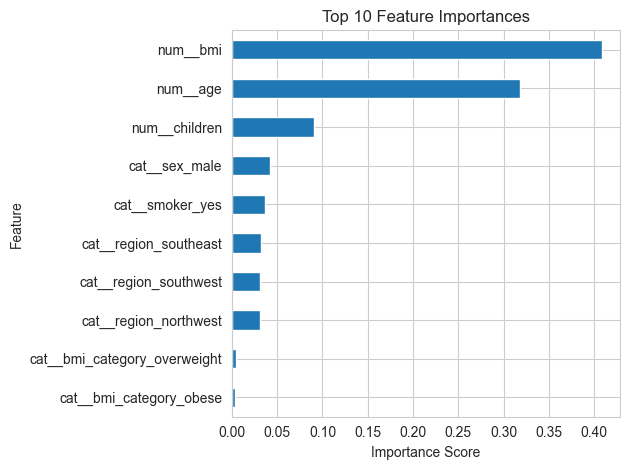

In [56]:
plt.figure(figsize=(8,5))
importance_df.head(10).plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False
)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("outputs/feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

# Error Analysis

In [38]:
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_best
})

results['Error'] = results['Actual'] - results['Predicted']
results.describe()

,Actual,Predicted,Error
count,268.000000,268.000000,268.000000
mean,12968.317063,14112.331249,-1144.014186
std,12483.196202,5725.305560,12258.839065
min,1131.506600,3264.187190,-24795.070564
25%,4288.744850,10026.332707,-8316.955314
50%,8487.880300,13719.382014,-4096.110281
75%,16367.829375,16869.942568,4938.440200
max,63770.428010,32749.513834,50904.652887


In [39]:
results.sort_values(by='Error', ascending=False).head()

,Actual,Predicted,Error
543,63770.42801,12865.775123,50904.652887
1323,43896.37630,9039.451775,34856.924525
175,48824.45000,15389.913831,33434.536169
739,44585.45587,11586.244411,32999.211459
1047,44501.39820,13812.957059,30688.441141


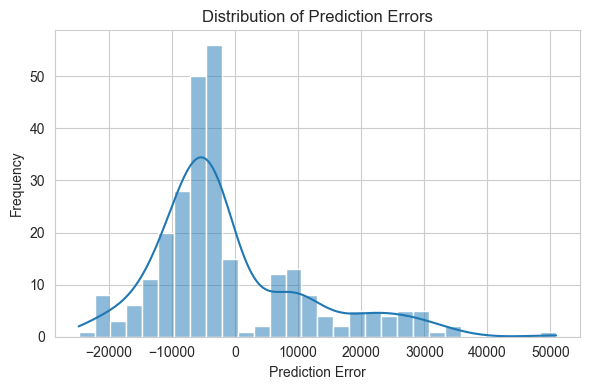

In [57]:
plt.figure(figsize=(6,4))
sns.histplot(results['Error'], bins=30, kde=True)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("outputs/error_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


# Example: Predicting Insurance Cost for a New Customer

In [40]:
new_customer = pd.DataFrame({
    'age': [35],
    'sex': ['male'],
    'bmi': [24.5],
    'children': [1],
    'smoker': ['no'],
    'region': ['southeast'],
    'bmi_category': ['normal']
})

In [41]:
# Predict Insurance Cost

In [42]:
predicted_cost = best_model.predict(new_customer)
print(f"Predicted insurance cost for the customer: ₹{predicted_cost[0]:,.2f}")

Predicted insurance cost for the customer: ₹10,874.65


In [43]:
# Model Usage Example

 # Final Business Conclusions